# **Project Introduction**
Verbal Communication is valuable and sought after in workplace and classroom environments alike.
There is no denying the notion that Indians lack verbal communication and consequently lag behind in
the workplace or classroom environments. This happens despite them having strong technical
competencies. Clear and comprehensive speech is the vital backbone of strong communication and
presentation skills. Where some occupations consist mainly of presenting, most careers require and
thrive from the ability to communicate effectively. Research has shown that verbal communication
remains one of the most employable skills in both the perception of employers and new graduates. Of
the possible improvements to vocal presentations tone, disfluencies, and stutters, in particular, remain
one of the most common and prominent factors of someone’s demonstration. Millions of people are
affected by stuttering and other speech disfluencies, with the majority of the world having experienced
mild stutters while communicating under stressful conditions. Research shows that mild disfluencies
can be cured without medical help, just practicing speech regularly and constructive feedbacks are
effective ways to improve.
We, Data Scientists recognize this problem and say hello.


# **Problem Statement**
We will solve the above-mentioned problem by applying deep learning algorithms to audio/speech
data. The solution will be to identify emotions in speech.

**DATA SOURCE USED**

We have used the RAVDESS dataset in this project.It is one of the more common dataset used for this excercise by others. It's well liked because of its quality of speakers, recording and it has 24 actors of different genders.
Here's the filename identifiers as per the official RAVDESS website:

* Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
* Vocal channel (01 = speech, 02 = song).
* Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
* Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
* Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
* Repetition (01 = 1st repetition, 02 = 2nd repetition).
* Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

Here's an example of an audio filename. 02-01-06-01-02-01-12.mp4

In [2]:
#IMPORT THE LIBRARIES
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#hide warnigs
import warnings  
warnings.filterwarnings(action='ignore')

In [3]:
# path to the dataset used in this project
RAV = "/content/drive/MyDrive/Colab Notebooks/Project/Speech/speech-emotion-recognition-ravdess-data/"

In [4]:
# Loading speech dataset and count according to the emotions-wise

dir_list = os.listdir(RAV)
dir_list.sort()

emotion = []
gender = []
path = []
for i in dir_list:
    fname = os.listdir(RAV + i)
    for f in fname:
        part = f.split('.')[0].split('-')
        emotion.append(int(part[2]))
        temp = int(part[6])
        if temp%2 == 0:
            temp = "female"
        else:
            temp = "male"
        gender.append(temp)
        path.append(RAV + i + '/' + f)

        
RAV_df = pd.DataFrame(emotion)
RAV_df = RAV_df.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'})
RAV_df = pd.concat([pd.DataFrame(gender),RAV_df],axis=1)
RAV_df.columns = ['gender','emotion']
RAV_df['labels'] =RAV_df.gender + '_' + RAV_df.emotion
RAV_df['source'] = 'RAVDESS'  
RAV_df = pd.concat([RAV_df,pd.DataFrame(path, columns = ['path'])],axis=1)
RAV_df = RAV_df.drop(['gender', 'emotion'], axis=1)
RAV_df.labels.value_counts()

male_angry         96
male_sad           96
female_angry       96
male_happy         96
male_fear          96
female_happy       96
female_disgust     96
female_surprise    96
female_calm        96
female_fear        96
male_calm          96
female_sad         96
male_surprise      96
male_disgust       96
female_neutral     48
male_neutral       48
Name: labels, dtype: int64

# EXPLORATORY DATA ANALYSIS
The key features of the audio data are namely, MFCC (Mel Frequency Cepstral Coefficients), Mel Spectrogram and Chroma.

MFCC (Mel Frequency Cepstral Coefficients)- MFCC is taken on a Mel scale which is a scale that relates the perceived frequency of a tone to the actual measured frequency. It scales the frequency in order to match more closely what the human ear can hear. The envelope of the temporal power spectrum of the speech signal is representative of the vocal tract and MFCC accurately represents this envelope.
Mel Spectrogram- A Fast Fourier Transform is computed on overlapping windowed segments of the signal, and we get what is called the spectrogram. This is just a spectrogram that depicts amplitude which is mapped on a Mel scale.

Chroma- A Chroma vector is typically a 12-element feature vector indicating how much energy of each pitch class is present in the signal in a standard chromatic scale.

For the EDA we have used MFCC and Mel Spectogram

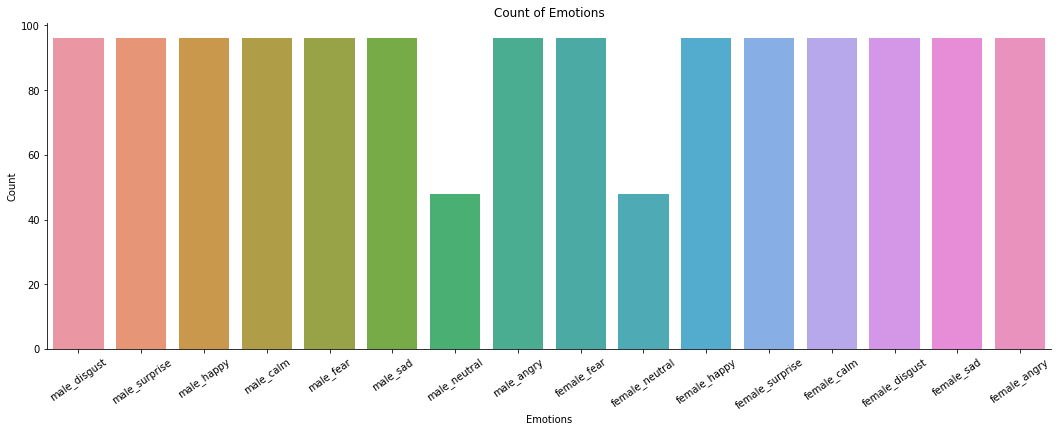

In [11]:
# visualize count of emotions-wise
plt.figure(figsize=(18,6))
plt.title('Count of Emotions', size=12)
sns.countplot(RAV_df.labels)
plt.ylabel('Count')
plt.xlabel('Emotions')
plt.xticks(rotation=35)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()